# Machine Learning

In [169]:
#Importamos las librerias
import pandas as pd
import numpy as np
import re
import category_encoders as ce
import spacy
import en_core_web_sm
import nltk
import sklearn
from pandas import DataFrame
from spacy import displacy
from wordcloud import WordCloud
from pandas import DataFrame
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import EnglishStemmer
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

plt.style.use('default')
nlp = en_core_web_sm.load()

## Funciones

In [2]:
#Cargo estas funciones para utilizarlas debajo
tknzr = TweetTokenizer()
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer('english')

In [3]:
stemmer_count = EnglishStemmer()
analyzer = CountVectorizer().build_analyzer()

In [4]:
#Funcion para definir la locacion
def MeQuedoConLocacion(Primero,Segundo,Tercero,Cuarto):
    if(pd.isna(Primero)) & (pd.isna(Segundo)) & (pd.isna(Tercero)):
        return 'Sin Locacion'
    if(pd.isna(Primero)) & (pd.isna(Segundo)) & (pd.notna(Tercero)):
        return Cuarto
    if(pd.isna(Primero)):
        return Segundo
    if(pd.isna(Segundo)):
        return Primero

In [5]:
#Funcion para hacer One Hot Encoding agregando un sufijo al nombre
def oneHotEncoding(df, columna, sufijo):
    one_hot = pd.get_dummies(df[columna])
    one_hot.columns = [str(col) + sufijo for col in one_hot.columns]
    df.drop(columna, axis=1, inplace=True)
    df = pd.concat([df, one_hot], axis=1)
    return df

In [6]:
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

In [7]:
def stemmed_words(doc):
    return (stemmer_count.stem(w) for w in analyzer(doc))

In [8]:
def MeQuedoEstado(abreviacion,estado):
    if(pd.isna(abreviacion)):
        return np.nan
    if(pd.notna(abreviacion)):
        return estado

In [9]:
def EstadoFinal(Est_Pri,Abbr_Pri,Est_Seg,Abbr_Seg):
    if(pd.isna(Est_Pri)) & (pd.isna(Abbr_Pri)) & (pd.isna(Est_Seg)) & (pd.isna(Abbr_Seg)):
        return np.nan
    if(pd.notna(Est_Pri)) & (pd.isna(Abbr_Pri)) & (pd.isna(Est_Seg)) & (pd.isna(Abbr_Seg)):
        return Est_Pri
    if(pd.isna(Est_Pri)) & (pd.notna(Abbr_Pri)) & (pd.isna(Est_Seg)) & (pd.isna(Abbr_Seg)):
        return Abbr_Pri
    if(pd.isna(Est_Pri)) & (pd.isna(Abbr_Pri)) & (pd.notna(Est_Seg)) & (pd.isna(Abbr_Seg)):
        return Est_Seg
    if(pd.isna(Est_Pri)) & (pd.isna(Abbr_Pri)) & (pd.isna(Est_Seg)) & (pd.notna(Abbr_Seg)):
        return Abbr_Seg

In [10]:
def EsNulo(campo):
    if(pd.isna(campo)):
        return 'EsNulo'
    if(pd.notna(campo)):
        return 'NoNulo'

### Carga de los CSVs

In [11]:
#Cargamos el set de entrenamiento
train=pd.read_csv('Data/train.csv')
train['text']=train['text'].str.lower()
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1
1,4,NaN,NaN,forest fire near la ronge sask. canada,1
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1


In [12]:
#Cargamos el csv de las Ciudades
ciudades=pd.read_csv('Data/worldcities.csv')
ciudades=ciudades[['city','country']]
ciudades.head()

,city,country
0,Tokyo,Japan
1,New York,United States
2,Mexico City,Mexico
3,Mumbai,India
4,São Paulo,Brazil


In [13]:
#Cargamos el csv con los Paises del mundo
mundo=pd.read_csv('Data/Mundo.csv')
mundo=mundo[['name','iso_a3']]
mundo.head()

,name,iso_a3
0,Fiji,FJI
1,Tanzania,TZA
2,W. Sahara,ESH
3,Canada,CAN
4,United States,USA


In [14]:
estados_usa=pd.read_csv('Data/Estados_USA.csv')
estados_usa.drop(columns={'Unnamed: 0'},inplace=True)
estados_usa.head()

,Nombre_Estado,Abreviacion_Estado
0,Washington,WA
1,Montana,MT
2,Maine,ME
3,North Dakota,ND
4,South Dakota,SD


In [15]:
#Cargamos el csv con los hashtags mas utilizados
hashtags=pd.read_csv('Data/Hashtags_Total.csv')
hashtags.set_index('Hashtag',inplace=True)
hashtags.head()

,Unnamed: 0
Hashtag,
News,1
Hot,0
Best,1609
Prebreak,1167
Nowplaying,3


In [16]:
#Cargamos el csv con las menciones mas utilizados
arrobas=pd.read_csv('Data/Arroba_Total.csv')
arrobas['Mencion']=arrobas['Mencion'].str.lower()
arrobas.set_index('Mencion',inplace=True)
arrobas.head()

,Unnamed: 0
Mencion,
youtube,0
arianagrande,3
foxnews,6
potus,7
change,1


## 1) Set de Entrenamiento

### 1.1) Generamos los Features

#### 1.1.1) Count Vectorizer

In [18]:
vectorizer = CountVectorizer(stop_words='english', analyzer=stemmed_words,min_df=2)

In [19]:
X_train = vectorizer.fit_transform(train['text']).toarray()

In [20]:
CountVectorizer_train=pd.DataFrame(X_train)
CountVectorizer_train.head()

,0,1,2,3,4,5,6,7,8,9,...,5517,5518,5519,5520,5521,5522,5523,5524,5525,5526
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 1.1.2) Analisis de Locacion

##### 1.1.2.1) Por País

In [21]:
#Separo la locacion por las comas
separacion_coma=pd.concat([train, train['location'].str.split(',', expand=True)], axis=1)
separacion_coma.rename(columns={0:'Primero',1:'Segundo',2:'Tercero'},inplace=True)
separacion_coma.drop(columns={'location',3},inplace=True)
separacion_coma.head()

,id,keyword,text,target,Primero,Segundo,Tercero
0,1,NaN,our deeds are the reason of this #earthquake m...,1,NaN,NaN,NaN
1,4,NaN,forest fire near la ronge sask. canada,1,NaN,NaN,NaN
2,5,NaN,all residents asked to 'shelter in place' are ...,1,NaN,NaN,NaN
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,NaN,NaN,NaN
4,7,NaN,just got sent this photo from ruby #alaska as ...,1,NaN,NaN,NaN


In [22]:
#Me quedo con la primer parte de la separación ya que vimos que es la más importante
#Mapeo para cada ciudad, su pais
primera_ciudad=separacion_coma[['id','Primero']].copy()
primera_ciudad.rename(columns={'Primero':'city'},inplace=True)
ciudad_pais=pd.merge(primera_ciudad,ciudades,on='city',how='left')
ciudad_pais.drop_duplicates(subset="id",keep="first",inplace=True)

In [23]:
#Mapeo para cada abreviacion, su pais
primera_abreviacion=separacion_coma[['id','Primero']].copy()
primera_abreviacion.rename(columns={'Primero':'iso_a3'},inplace=True)
abreviacion_pais=pd.merge(primera_abreviacion,mundo,on='iso_a3',how='left')
abreviacion_pais.drop_duplicates(subset="id",keep="first",inplace=True)

In [24]:
#Verifico si en la primer coma esta bien la locacion
primera_pais=separacion_coma[['id','Primero']].copy()
primera_pais.rename(columns={'Primero':'name'},inplace=True)
pais=pd.merge(primera_pais,mundo,on='name',how='left')
pais.drop_duplicates(subset="id",keep="first",inplace=True)
pais.rename(columns={'iso_a3':'abreviacion'},inplace=True)
pais.drop(columns={'name'},inplace=True)

In [25]:
#Junto todo en un solo DataFrame para quedarme con el Pais
junto=pd.merge(abreviacion_pais,ciudad_pais,on='id',how='inner')
junto=pd.merge(junto,pais,on='id',how='inner')
junto['Locacion']=junto.apply(lambda x: MeQuedoConLocacion(x['name'],x['country'],x['abreviacion'],x['iso_a3']),axis=1)
junto_final=junto[['id','Locacion']]

#Lo Joineo con el set de entrenamiento
train=pd.merge(train,junto_final,on='id',how='inner')
train.head()

,id,keyword,location,text,target,Locacion
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1,Sin Locacion
1,4,NaN,NaN,forest fire near la ronge sask. canada,1,Sin Locacion
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1,Sin Locacion
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,Sin Locacion
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1,Sin Locacion


##### 1.1.2.1) Por Estado

In [26]:
#Me quedo con la primer parte de la separación ya que vimos que es la más importante
#Mapeo para cada estado, su abreviación
primera_estado=separacion_coma[['id','Primero']].copy()
primera_estado.rename(columns={'Primero':'Nombre_Estado'},inplace=True)
primera_estado_nombre=pd.merge(primera_estado,estados_usa,on='Nombre_Estado',how='left')
primera_estado_nombre.drop_duplicates(subset="id",keep="first",inplace=True)
primera_estado_nombre['Estado_Nombre_Primero']=primera_estado_nombre.apply(lambda x: MeQuedoEstado(x['Abreviacion_Estado'],x['Nombre_Estado']),axis=1)
primera_estado_nombre.drop(columns={'Nombre_Estado','Abreviacion_Estado'},inplace=True)

In [27]:
#Mapeo para cada abreviación, su estado
primera_abreviacion=separacion_coma[['id','Primero']].copy()
primera_abreviacion.rename(columns={'Primero':'Abreviacion_Estado'},inplace=True)
primera_estado_abreviacion=pd.merge(primera_abreviacion,estados_usa,on='Abreviacion_Estado',how='left')
primera_estado_abreviacion.drop_duplicates(subset="id",keep="first",inplace=True)
primera_estado_abreviacion['Estado_Abreviacion_Primero']=primera_estado_abreviacion.apply(lambda x: MeQuedoEstado(x['Abreviacion_Estado'],x['Nombre_Estado']),axis=1)
primera_estado_abreviacion.drop(columns={'Nombre_Estado','Abreviacion_Estado'},inplace=True)

In [28]:
#lo mismo que antes pero con la segunda parte de la coma
#Mapeo para cada estado, su abreviación
segunda_estado=separacion_coma[['id','Segundo']].copy()
segunda_estado.rename(columns={'Segundo':'Nombre_Estado'},inplace=True)
segunda_estado_nombre=pd.merge(segunda_estado,estados_usa,on='Nombre_Estado',how='left')
segunda_estado_nombre.drop_duplicates(subset="id",keep="first",inplace=True)
segunda_estado_nombre['Estado_Nombre_Segunda']=segunda_estado_nombre.apply(lambda x: MeQuedoEstado(x['Abreviacion_Estado'],x['Nombre_Estado']),axis=1)
segunda_estado_nombre.drop(columns={'Nombre_Estado','Abreviacion_Estado'},inplace=True)

In [29]:
#Mapeo para cada abreviación, su estado
segunda_abreviacion=separacion_coma[['id','Segundo']].copy()
segunda_abreviacion.rename(columns={'Segundo':'Abreviacion_Estado'},inplace=True)
segunda_estado_abreviacion=pd.merge(segunda_abreviacion,estados_usa,on='Abreviacion_Estado',how='left')
segunda_estado_abreviacion.drop_duplicates(subset="id",keep="first",inplace=True)
segunda_estado_abreviacion['Estado_Abreviacion_Segunda']=segunda_estado_abreviacion.apply(lambda x: MeQuedoEstado(x['Abreviacion_Estado'],x['Nombre_Estado']),axis=1)
segunda_estado_abreviacion.drop(columns={'Nombre_Estado','Abreviacion_Estado'},inplace=True)

In [30]:
#Junto todo en un solo DataFrame para quedarme con el Estado
estados_final=pd.merge(primera_estado_nombre,primera_estado_abreviacion,on='id',how='inner')
estados_final=pd.merge(estados_final,segunda_estado_nombre,on='id',how='inner')
estados_final=pd.merge(estados_final,segunda_estado_abreviacion,on='id',how='inner')
estados_final['Estado']=estados_final.apply(lambda x: EstadoFinal(x['Estado_Nombre_Primero'],x['Estado_Abreviacion_Primero'],x['Estado_Nombre_Segunda'],x['Estado_Abreviacion_Segunda']),axis=1)
estados_final.drop(columns={'Estado_Nombre_Primero','Estado_Abreviacion_Primero','Estado_Nombre_Segunda','Estado_Abreviacion_Segunda'},inplace=True)

#Lo Joineo con el set de entrenamiento
train=pd.merge(train,estados_final,on='id',how='inner')
train.head()

,id,keyword,location,text,target,Locacion,Estado
0,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1,Sin Locacion,NaN
1,4,NaN,NaN,forest fire near la ronge sask. canada,1,Sin Locacion,NaN
2,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1,Sin Locacion,NaN
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,Sin Locacion,NaN
4,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1,Sin Locacion,NaN


#### 1.1.3) Analisis Sintáctico

In [31]:
#Parse del texto , donde cada token es una palabra

for i, row in train.iterrows():
  
    if(row["text"] and len(str(row["text"])) < 300):
        doc = nlp(str(row["text"]))
        
        adjectives = []
        nouns = []
        verbs = []
        lemmas = []
        simbolos = []
        alfanumericos = []

        for token in doc:
            
            lemmas.append(token.lemma_)
            
            if not token.text.isalpha():
                alfanumericos.append(token.lemma_)
            if token.pos_ == "ADJ":
                adjectives.append(token.lemma_)
            if token.pos_ == "NOUN" or token.pos_ == "PROPN":
                nouns.append(token.lemma_)
            if token.pos_ == "VERB":
                verbs.append(token.lemma_)
            if token.pos_ == "SYM":
                simbolos.append(token.lemma_)
         
        train.at[i, "adjetivos"] = " ".join(adjectives)
        train.at[i, "verbos"] = " ".join(verbs)
        train.at[i, "longitud"] = len(row["text"])
        train.at[i, "cant_tokens"] = len(lemmas)
        
print('Completado')

Completado


In [32]:
train['rango_longitud']=pd.cut(train['longitud'],[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200])
train['rango_palabras']=pd.cut(train['cant_tokens'],[0,10,20,30,40,50,60,70,80,90,100])

In [33]:
train_reales = train.loc[ train['target'] == 1]
train_fake = train.loc[ train['target'] == 0]

verbos_reales = train_reales['verbos'].astype('str').str.lower().value_counts()
verbos_fake = train_fake['verbos'].astype('str').str.upper().value_counts()

adjetivos_reales = train_reales['adjetivos'].astype('str').str.lower().value_counts()
adjetivos_fake = train_fake['adjetivos'].astype('str').str.lower().value_counts()

In [34]:
#Me quedo con la cantidad que considere necesario
top_20_keywords = train['keyword'].value_counts().head(50).index
top_20_verbos = train['verbos'].astype('str').value_counts().head(100).index
top_20_verbos_reales = verbos_reales.head(100).index
top_20_verbos_fake = verbos_fake.head(100).index
top_20_adjetivos = train['adjetivos'].astype('str').value_counts().head(100).index
top_20_adjetivos_reales = adjetivos_reales.head(100).index
top_20_adjetivos_fake =  adjetivos_fake.head(100).index
top_50_locaciones = train['Locacion'].astype('str').value_counts().head(50).index
top_10_hashtags = hashtags.head(70).index
top_10_arrobas = arrobas.head(70).index
top_estados = train['Estado'].astype('str').value_counts().head(10).index

In [35]:
#Agrego un booleano con respecto a si tienen los simbolos enunciados
train['Tiene_arroba']=train['text'].str.contains('@')
train['Tiene_hashtag']=train['text'].str.contains('#')
train['Tiene_signo_pregunta']=train['text'].str.contains('\?|¿')
train['Tiene_signo_exclamacion']=train['text'].str.contains('!|¡')

In [36]:
#Veo si los campos keyword y location son nulos
train['Keyword_Nula']=train.apply(lambda x: EsNulo(x['keyword']),axis=1)
train['Locacion_Nula']=train.apply(lambda x: EsNulo(x['location']),axis=1)

In [37]:
english_stopwords = stopwords.words('english')
stemmer = SnowballStemmer('english')

aQuitar = ['http','https','&amp']
english_stopwords.extend(aQuitar)

In [38]:
texto = train["text"]

textoVeridico = train[(train['target']==1)]
textoVeridico = textoVeridico["text"]

textoFalso = train[(train['target']==0)]
textoFalso = textoFalso["text"]

In [39]:
palabrasVeridicas=[]
for row in textoVeridico:
    row =row.lower()
    row=filter(None, re.split("[, \-!?:._¡¿'`<>;()+]", row))
    for palabra in row:
        if len(palabra)<4: #saco conectores
            continue
        if palabra not in english_stopwords:
            palabrasVeridicas.append(palabra)

In [40]:
palabrasFalsas=[]
for row in textoFalso:
    row =row.lower()
    row=filter(None, re.split("[, \-!?:._¡¿'`<>;()+]", row))
    for palabra in row:
        if len(palabra)<4: #saco conectores
            continue
        if palabra not in english_stopwords:
            palabrasFalsas.append(palabra)

In [41]:
contador = Counter(palabrasVeridicas)
palabrasComunesVeridicas = contador.most_common(300)
dfPalabrasComunesV = DataFrame(palabrasComunesVeridicas,columns=['Palabra','Cantidad'])

In [42]:
contador = Counter(palabrasFalsas)
palabrasComunesFalsas = contador.most_common(300)
dfPalabrasComunesF = DataFrame(palabrasComunesFalsas,columns=['Palabra','Cantidad'])

In [43]:
popularesEnComun = dfPalabrasComunesV.merge(dfPalabrasComunesF,left_on='Palabra',right_on='Palabra',how='inner')

In [44]:
popularesExclusivamenteV = dfPalabrasComunesV[(~dfPalabrasComunesV.Palabra.isin(popularesEnComun.Palabra))]
popularesExclusivamenteF = dfPalabrasComunesF[(~dfPalabrasComunesF.Palabra.isin(popularesEnComun.Palabra))]

In [45]:
TopPopularesExclusivamenteV = popularesExclusivamenteV.nlargest(300, 'Cantidad')
TopPopularesExclusivamenteV.sort_values('Cantidad',inplace=True)

In [46]:
TopPopularesExclusivamenteF = popularesExclusivamenteF.nlargest(300, 'Cantidad')
TopPopularesExclusivamenteF.sort_values('Cantidad',inplace=True)

#### 1.1.4) Aplicación de los procesamientos

In [47]:
train = oneHotEncoding(train,'rango_longitud','_longiud')
train = oneHotEncoding(train,'rango_palabras','_palabras')
train = oneHotEncoding(train,'Keyword_Nula','_Keyword')
train = oneHotEncoding(train,'Locacion_Nula','_Locacion')

In [48]:
for columna in popularesExclusivamenteV['Palabra']:
    train[columna+'_text']=train.text.str.contains(columna,case=False)

In [49]:
for columna in popularesExclusivamenteF['Palabra']:
    train[columna+'_text']=train.text.str.contains(columna,case=False)

In [50]:
for est in top_estados:
    train[est]=train['Estado'].str.contains(est,case=False)

In [51]:
for key_top in top_20_keywords:
    train[key_top]=train['keyword'].str.contains(key_top,case=False)

In [52]:
for verbo_top in top_20_verbos:
    train[verbo_top+'_total']=train['verbos'].str.contains(verbo_top,case=False)

In [53]:
for adjetivos_top in top_20_adjetivos:
    train[adjetivos_top+'_total']=train['adjetivos'].str.contains(adjetivos_top,case=False)

In [54]:
for verbo_real in top_20_verbos_reales:
    train[verbo_real+'_real']=train['verbos'].str.contains(verbo_real,case=False)

In [55]:
for verbo_fake in top_20_verbos_fake:
    train[verbo_fake+'_fake']=train['verbos'].str.contains(verbo_fake,case=False)

In [56]:
for adjetivos_real in top_20_adjetivos_reales:
    train[adjetivos_real+'_real']=train['adjetivos'].str.contains(adjetivos_real,case=False)

In [57]:
for adjetivos_fake in top_20_adjetivos_fake:
    train[adjetivos_fake+'_fake']=train['adjetivos'].str.contains(adjetivos_fake,case=False)

In [58]:
for locacion_top in top_50_locaciones:
    train[locacion_top]=train['Locacion'].str.contains(locacion_top,case=False)

In [59]:
for hastag_top in top_10_hashtags:
    train[hastag_top]=train['text'].str.contains('#'+hastag_top,case=False)

In [60]:
for arroba_top in top_10_arrobas:
    train[arroba_top]=train['text'].str.contains('@'+arroba_top,case=False)

In [61]:
#Quito las columnas que no necesito y relleno los NaNs con False
train.drop(columns={'Estado','cant_tokens','location','Locacion','keyword','text','adjetivos','verbos','longitud'},inplace=True)
train.fillna(False,inplace=True)
train_final=pd.concat((CountVectorizer_train,train),axis=1)
train_final.head()

,0,1,2,3,4,5,6,7,8,9,...,refugees,guardian,claytonbryant,realmandyrain,zak_bagans,accionempresa,wocowae,narendramodi,rohnertparkdps,spencers
0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
3,0,1,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
4,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False


## 2) Set de Test

Lo mismo que se realizo para el set de entrenamiento se hace para el de test

In [62]:
#Cargo el csv
test=pd.read_csv('Data/test.csv')
test['text']=test['text'].str.lower()
test.head()

,id,keyword,location,text
0,0,NaN,NaN,just happened a terrible car crash
1,2,NaN,NaN,"heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,apocalypse lighting. #spokane #wildfires
4,11,NaN,NaN,typhoon soudelor kills 28 in china and taiwan


### 2.1) Generamos los Features

#### 2.1.1) Count Vectorizer

In [63]:
XTest = vectorizer.transform(test['text']).toarray()

In [64]:
XTest.shape

(3263, 5527)

In [65]:
CountVectorizer_test = pd.DataFrame(XTest)
CountVectorizer_test.head()

,0,1,2,3,4,5,6,7,8,9,...,5517,5518,5519,5520,5521,5522,5523,5524,5525,5526
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 2.1.2) Analisis de Locacion

##### 2.1.2.1) Por País

In [66]:
#Mismo procedimiento que en el set de entrenamiento
separacion_coma_test=pd.concat([test, test['location'].str.split(',', expand=True)], axis=1)
separacion_coma_test.rename(columns={0:'Primero',1:'Segundo',2:'Tercero'},inplace=True)
separacion_coma_test.drop(columns={'location',3},inplace=True)
separacion_coma_test.head()

,id,keyword,text,Primero,Segundo,Tercero
0,0,NaN,just happened a terrible car crash,NaN,NaN,NaN
1,2,NaN,"heard about #earthquake is different cities, s...",NaN,NaN,NaN
2,3,NaN,"there is a forest fire at spot pond, geese are...",NaN,NaN,NaN
3,9,NaN,apocalypse lighting. #spokane #wildfires,NaN,NaN,NaN
4,11,NaN,typhoon soudelor kills 28 in china and taiwan,NaN,NaN,NaN


In [67]:
primera_ciudad_test=separacion_coma_test[['id','Primero']].copy()
primera_ciudad_test.rename(columns={'Primero':'city'},inplace=True)
ciudad_pais_test=pd.merge(primera_ciudad_test,ciudades,on='city',how='left')
ciudad_pais_test.drop_duplicates(subset="id",keep="first",inplace=True)

In [68]:
primera_abreviacion_test=separacion_coma_test[['id','Primero']].copy()
primera_abreviacion_test.rename(columns={'Primero':'iso_a3'},inplace=True)
abreviacion_pais_test=pd.merge(primera_abreviacion_test,mundo,on='iso_a3',how='left')
abreviacion_pais_test.drop_duplicates(subset="id",keep="first",inplace=True)

In [69]:
primera_pais_test=separacion_coma_test[['id','Primero']].copy()
primera_pais_test.rename(columns={'Primero':'name'},inplace=True)
pais_test=pd.merge(primera_pais_test,mundo,on='name',how='left')
pais_test.drop_duplicates(subset="id",keep="first",inplace=True)
pais_test.rename(columns={'iso_a3':'abreviacion'},inplace=True)
pais_test.drop(columns={'name'},inplace=True)

In [70]:
junto_test=pd.merge(abreviacion_pais_test,ciudad_pais_test,on='id',how='inner')
junto_test=pd.merge(junto_test,pais_test,on='id',how='inner')
junto_test['Locacion']=junto_test.apply(lambda x: MeQuedoConLocacion(x['name'],x['country'],x['abreviacion'],x['iso_a3']),axis=1)
junto_final_test=junto_test[['id','Locacion']]

#Lo Joineo con el set de Test
test=pd.merge(test,junto_final_test,on='id',how='inner')
test.head()

,id,keyword,location,text,Locacion
0,0,NaN,NaN,just happened a terrible car crash,Sin Locacion
1,2,NaN,NaN,"heard about #earthquake is different cities, s...",Sin Locacion
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",Sin Locacion
3,9,NaN,NaN,apocalypse lighting. #spokane #wildfires,Sin Locacion
4,11,NaN,NaN,typhoon soudelor kills 28 in china and taiwan,Sin Locacion


##### 2.1.2.2) Por Estado

In [71]:
primera_estado_test=separacion_coma_test[['id','Primero']].copy()
primera_estado_test.rename(columns={'Primero':'Nombre_Estado'},inplace=True)
primera_estado_nombre_test=pd.merge(primera_estado_test,estados_usa,on='Nombre_Estado',how='left')
primera_estado_nombre_test.drop_duplicates(subset="id",keep="first",inplace=True)
primera_estado_nombre_test['Estado_Nombre_Primero']=primera_estado_nombre_test.apply(lambda x: MeQuedoEstado(x['Abreviacion_Estado'],x['Nombre_Estado']),axis=1)
primera_estado_nombre_test.drop(columns={'Nombre_Estado','Abreviacion_Estado'},inplace=True)

In [72]:
primera_abreviacion_test=separacion_coma_test[['id','Primero']].copy()
primera_abreviacion_test.rename(columns={'Primero':'Abreviacion_Estado'},inplace=True)
primera_estado_abreviacion_test=pd.merge(primera_abreviacion_test,estados_usa,on='Abreviacion_Estado',how='left')
primera_estado_abreviacion_test.drop_duplicates(subset="id",keep="first",inplace=True)
primera_estado_abreviacion_test['Estado_Abreviacion_Primero']=primera_estado_abreviacion_test.apply(lambda x: MeQuedoEstado(x['Abreviacion_Estado'],x['Nombre_Estado']),axis=1)
primera_estado_abreviacion_test.drop(columns={'Nombre_Estado','Abreviacion_Estado'},inplace=True)

In [73]:
segunda_estado_test=separacion_coma_test[['id','Segundo']].copy()
segunda_estado_test.rename(columns={'Segundo':'Nombre_Estado'},inplace=True)
segunda_estado_nombre_test=pd.merge(segunda_estado_test,estados_usa,on='Nombre_Estado',how='left')
segunda_estado_nombre_test.drop_duplicates(subset="id",keep="first",inplace=True)
segunda_estado_nombre_test['Estado_Nombre_Segunda']=segunda_estado_nombre_test.apply(lambda x: MeQuedoEstado(x['Abreviacion_Estado'],x['Nombre_Estado']),axis=1)
segunda_estado_nombre_test.drop(columns={'Nombre_Estado','Abreviacion_Estado'},inplace=True)

In [74]:
segunda_abreviacion_test=separacion_coma_test[['id','Segundo']].copy()
segunda_abreviacion_test.rename(columns={'Segundo':'Abreviacion_Estado'},inplace=True)
segunda_estado_abreviacion_test=pd.merge(segunda_abreviacion_test,estados_usa,on='Abreviacion_Estado',how='left')
segunda_estado_abreviacion_test.drop_duplicates(subset="id",keep="first",inplace=True)
segunda_estado_abreviacion_test['Estado_Abreviacion_Segunda']=segunda_estado_abreviacion_test.apply(lambda x: MeQuedoEstado(x['Abreviacion_Estado'],x['Nombre_Estado']),axis=1)
segunda_estado_abreviacion_test.drop(columns={'Nombre_Estado','Abreviacion_Estado'},inplace=True)

In [75]:
estados_final_test=pd.merge(primera_estado_nombre_test,primera_estado_abreviacion_test,on='id',how='inner')
estados_final_test=pd.merge(estados_final_test,segunda_estado_nombre_test,on='id',how='inner')
estados_final_test=pd.merge(estados_final_test,segunda_estado_abreviacion_test,on='id',how='inner')
estados_final_test['Estado']=estados_final_test.apply(lambda x: EstadoFinal(x['Estado_Nombre_Primero'],x['Estado_Abreviacion_Primero'],x['Estado_Nombre_Segunda'],x['Estado_Abreviacion_Segunda']),axis=1)
estados_final_test.drop(columns={'Estado_Nombre_Primero','Estado_Abreviacion_Primero','Estado_Nombre_Segunda','Estado_Abreviacion_Segunda'},inplace=True)

#Lo Joineo con el set de Test
test=pd.merge(test,estados_final_test,on='id',how='inner')
test.head()

,id,keyword,location,text,Locacion,Estado
0,0,NaN,NaN,just happened a terrible car crash,Sin Locacion,NaN
1,2,NaN,NaN,"heard about #earthquake is different cities, s...",Sin Locacion,NaN
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",Sin Locacion,NaN
3,9,NaN,NaN,apocalypse lighting. #spokane #wildfires,Sin Locacion,NaN
4,11,NaN,NaN,typhoon soudelor kills 28 in china and taiwan,Sin Locacion,NaN


#### 2.1.3) Analisis Sintactico

In [76]:
#Parse del texto , donde cada token es una palabra

for i, row in test.iterrows():
  
    if(row["text"] and len(str(row["text"])) < 300):
        doc = nlp(str(row["text"]))
        
        adjectives = []
        nouns = []
        verbs = []
        lemmas = []
        simbolos = []
        alfanumericos = []

        for token in doc:
            
            lemmas.append(token.lemma_)
            
            if not token.text.isalpha():
                alfanumericos.append(token.lemma_)
            if token.pos_ == "ADJ":
                adjectives.append(token.lemma_)
            if token.pos_ == "NOUN" or token.pos_ == "PROPN":
                nouns.append(token.lemma_)
            if token.pos_ == "VERB":
                verbs.append(token.lemma_)
            if token.pos_ == "SYM":
                simbolos.append(token.lemma_)
         
        test.at[i, "adjetivos"] = " ".join(adjectives)
        test.at[i, "verbos"] = " ".join(verbs)
        test.at[i, "longitud"] = len(row["text"])
        test.at[i, "cant_tokens"] = len(lemmas)
        
print('Completado')

Completado


In [77]:
test['rango_longitud']=pd.cut(test['longitud'],[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200])
test['rango_palabras']=pd.cut(test['cant_tokens'],[0,10,20,30,40,50,60,70,80,90,100])

In [78]:
#Agrego un booleano con respecto a si tienen los simbolos enunciados
test['Tiene_arroba']=test['text'].str.contains('@')
test['Tiene_hashtag']=test['text'].str.contains('#')
test['Tiene_signo_pregunta']=test['text'].str.contains('\?|¿')
test['Tiene_signo_exclamacion']=test['text'].str.contains('!|¡')

In [79]:
#Veo si los campos keyword y location son nulos
test['Keyword_Nula']=test.apply(lambda x: EsNulo(x['keyword']),axis=1)
test['Locacion_Nula']=test.apply(lambda x: EsNulo(x['location']),axis=1)

#### 2.1.4) Aplicación de los procesamientos

In [80]:
test = oneHotEncoding(test,'rango_longitud','_longiud')
test = oneHotEncoding(test,'rango_palabras','_palabras')
test = oneHotEncoding(test,'Keyword_Nula','_Keyword')
test = oneHotEncoding(test,'Locacion_Nula','_Locacion')

In [81]:
for columna in popularesExclusivamenteV['Palabra']:
    test[columna+'_text']=test.text.str.contains(columna,case=False)

In [82]:
for columna in popularesExclusivamenteF['Palabra']:
    test[columna+'_text']=test.text.str.contains(columna,case=False)

In [83]:
for est in top_estados:
    test[est]=test['Estado'].str.contains(est,case=False)

In [84]:
for key_top in top_20_keywords:
    test[key_top]=test['keyword'].str.contains(key_top,case=False)

In [85]:
for verbo_top in top_20_verbos:
    test[verbo_top+'_total']=test['verbos'].str.contains(verbo_top,case=False)

In [86]:
for adjetivos_top in top_20_adjetivos:
    test[adjetivos_top+'_total']=test['adjetivos'].str.contains(adjetivos_top,case=False)

In [87]:
for verbo_real in top_20_verbos_reales:
    test[verbo_real+'_real']=test['verbos'].str.contains(verbo_real,case=False)

In [88]:
for verbo_fake in top_20_verbos_fake:
    test[verbo_fake+'_fake']=test['verbos'].str.contains(verbo_fake,case=False)

In [89]:
for adjetivos_real in top_20_adjetivos_reales:
    test[adjetivos_real+'_real']=test['adjetivos'].str.contains(adjetivos_real,case=False)

In [90]:
for adjetivos_fake in top_20_adjetivos_fake:
    test[adjetivos_fake+'_fake']=test['adjetivos'].str.contains(adjetivos_fake,case=False)

In [91]:
for locacion_top in top_50_locaciones:
    test[locacion_top]=test['location'].str.contains(locacion_top,case=False)

In [92]:
for hastag_top in top_10_hashtags:
    test[hastag_top]=test['text'].str.contains('#'+hastag_top,case=False)

In [93]:
for arroba_top in top_10_arrobas:
    test[arroba_top]=test['text'].str.contains('@'+arroba_top,case=False)

In [94]:
test.drop(columns={'Estado','cant_tokens','location','Locacion','keyword','text','adjetivos','verbos','longitud'},inplace=True)
test.fillna(False,inplace=True)
test_final=pd.concat((CountVectorizer_test,test),axis=1)
test_final.head()

,0,1,2,3,4,5,6,7,8,9,...,refugees,guardian,claytonbryant,realmandyrain,zak_bagans,accionempresa,wocowae,narendramodi,rohnertparkdps,spencers
0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
3,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
4,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False


## 3) Aplicacion de Algoritmos

### Dividimos el set de entrenamiento en Entrenamiento y Validación

In [95]:
datos=train_final.drop(columns={'target'})
precio=train_final['target']
datos.head()

,0,1,2,3,4,5,6,7,8,9,...,refugees,guardian,claytonbryant,realmandyrain,zak_bagans,accionempresa,wocowae,narendramodi,rohnertparkdps,spencers
0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
1,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
2,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
3,0,1,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False
4,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,False


In [96]:
#Separamos el set de entrenamiento en set de entrenamiento y de validacion
test_size = 0.33
random_state = 0
datos_train , datos_test, target_train, target_test = train_test_split(datos,precio,test_size = test_size,random_state = random_state)

In [97]:
sc = StandardScaler()
sc.fit(datos_train)

datos_train_std = sc.transform(datos_train)
datos_test_std = sc.transform(datos_test)

In [98]:
#Normalizo el set de test
test_std = sc.transform(test_final)

### 3.1) Perceptron

#### 3.1.1) Penalty

##### 3.1.1.1) L1

In [195]:
perceptron_l1 = Perceptron(eta0 = 0.1,random_state = random_state,shuffle=True,penalty='l1')
perceptron_l1.fit(datos_train_std,target_train)

prediccion_perceptron_l1 = perceptron_l1.predict(datos_test_std)

print('Porcentaje: {0:.2f}%'.format(accuracy_score(target_test,prediccion_perceptron_l1)*100))

Porcentaje: 75.05%


##### 3.1.1.2) L2

In [196]:
perceptron_l2 = Perceptron(eta0 = 0.1,random_state = random_state,shuffle=True,penalty='l2')
perceptron_l2.fit(datos_train_std,target_train)

prediccion_perceptron_l2 = perceptron_l2.predict(datos_test_std)

print('Porcentaje: {0:.2f}%'.format(accuracy_score(target_test,prediccion_perceptron_l2)*100))

Porcentaje: 74.45%


##### 3.1.1.3) Elasticnet

In [197]:
perceptron_elasticnet = Perceptron(eta0 = 0.1,random_state = random_state,shuffle=True,penalty='elasticnet')
perceptron_elasticnet.fit(datos_train_std,target_train)

prediccion_perceptron_elasticnet = perceptron_elasticnet.predict(datos_test_std)

print('Porcentaje: {0:.2f}%'.format(accuracy_score(target_test,prediccion_perceptron_elasticnet)*100))

Porcentaje: 74.45%


#### 3.1.2) Prediccion Final

In [122]:
perceptron = Perceptron(eta0 = 0.1,random_state = random_state,shuffle=True,penalty='l1')

In [123]:
perceptron.fit(datos_train_std,target_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=0.1,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [125]:
prediccion_test_perceptron = perceptron.predict(test_std)

In [126]:
test_perceptron=test_final.copy()
test_perceptron['target']=prediccion_test_perceptron
test_perceptron.head()

,0,1,2,3,4,5,6,7,8,9,...,guardian,claytonbryant,realmandyrain,zak_bagans,accionempresa,wocowae,narendramodi,rohnertparkdps,spencers,target
0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0
1,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0
2,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1
3,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1
4,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1


In [104]:
entregable_perceptron=test_perceptron[['id','target']]
entregable_perceptron.set_index('id',inplace=True)
entregable_perceptron.head()

,target
id,
0,0
2,0
3,1
9,1
11,1


In [105]:
entregable_perceptron.to_csv('Resultados/Perceptron_Count_2.csv')

### 3.2) Random Forest

In [269]:
#Busco el Nro. Estimadores que nos de el mejor porcentaje
rango_n = range(100, 1200, 50)
porcentajes_RF=[]

for n in rango_n:
    RF = RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=n, oob_score=True,max_features='log2',min_samples_split=50)
    RF.fit(datos_train,target_train)
    prediccion_RF_validacion=RF.predict(datos_test)
    porcentaje_RF=(accuracy_score(target_test,prediccion_RF_validacion)*100)

    print('Nro. Estimadores =',n,'- Porcentaje: {0:.2f}%'.format(porcentaje_RF))
    porcentajes_RF.append(porcentaje_RF)

Nro. Estimadores = 100 - Porcentaje: 80.70%
Nro. Estimadores = 150 - Porcentaje: 81.02%
Nro. Estimadores = 200 - Porcentaje: 80.86%
Nro. Estimadores = 250 - Porcentaje: 80.66%
Nro. Estimadores = 300 - Porcentaje: 80.78%
Nro. Estimadores = 350 - Porcentaje: 80.94%
Nro. Estimadores = 400 - Porcentaje: 81.14%
Nro. Estimadores = 450 - Porcentaje: 81.18%
Nro. Estimadores = 500 - Porcentaje: 81.34%
Nro. Estimadores = 550 - Porcentaje: 81.26%
Nro. Estimadores = 600 - Porcentaje: 81.30%
Nro. Estimadores = 650 - Porcentaje: 81.26%
Nro. Estimadores = 700 - Porcentaje: 81.26%
Nro. Estimadores = 750 - Porcentaje: 81.34%
Nro. Estimadores = 800 - Porcentaje: 81.18%
Nro. Estimadores = 850 - Porcentaje: 81.26%
Nro. Estimadores = 900 - Porcentaje: 81.10%
Nro. Estimadores = 950 - Porcentaje: 81.06%
Nro. Estimadores = 1000 - Porcentaje: 81.06%
Nro. Estimadores = 1050 - Porcentaje: 81.10%
Nro. Estimadores = 1100 - Porcentaje: 81.18%
Nro. Estimadores = 1150 - Porcentaje: 81.14%


Text(0, 0.5, 'Porcentaje')

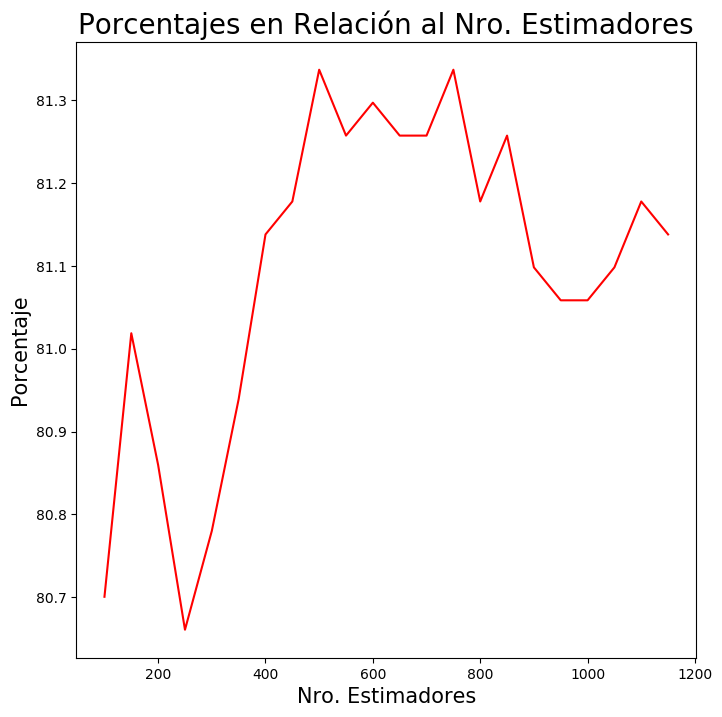

In [270]:
#Ploteamos para ver una mejor representacion
plt.subplots(figsize=(8,8))
plt.plot(rango_n,porcentajes_RF,color='red')
plt.title("Porcentajes en Relación al Nro. Estimadores",fontsize=20)
plt.xlabel("Nro. Estimadores",fontsize=15)
plt.ylabel("Porcentaje",fontsize=15)

#### 3.2.1) Predicción Final

In [271]:
RF = RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=500, oob_score=True,max_features='log2',min_samples_split=50)

In [272]:
RF.fit(datos_train,target_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

In [273]:
prediccion_test_RF = RF.predict(test_final)

In [274]:
test_RF=test_final.copy()
test_RF['target']=prediccion_test_RF
test_RF.head()

,0,1,2,3,4,5,6,7,8,9,...,guardian,claytonbryant,realmandyrain,zak_bagans,accionempresa,wocowae,narendramodi,rohnertparkdps,spencers,target
0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0
1,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1
2,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1
3,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1
4,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1


In [275]:
entregable_RF=test_RF[['id','target']]
entregable_RF.set_index('id',inplace=True)
entregable_RF.head()

,target
id,
0,0
2,1
3,1
9,1
11,1


In [276]:
entregable_RF.to_csv('Resultados/RF_Count_14.csv')

### 3.3) Naive Bayes

In [106]:
gnb = GaussianNB()

In [107]:
gnb.fit(datos_train,target_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [108]:
prediccion_gnb = gnb.predict(datos_test)

print('Porcentaje: {0:.2f}%'.format(accuracy_score(target_test,prediccion_gnb)*100))

Porcentaje: 79.07%


In [109]:
prediccion_test_gnb = gnb.predict(test_final)

In [110]:
test_gnb=test_final.copy()
test_gnb['target']=prediccion_test_gnb
test_gnb.head()

,0,1,2,3,4,5,6,7,8,9,...,guardian,claytonbryant,realmandyrain,zak_bagans,accionempresa,wocowae,narendramodi,rohnertparkdps,spencers,target
0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0
1,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0
2,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1
3,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1
4,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1


In [111]:
entregable_gnb=test_gnb[['id','target']]
entregable_gnb.set_index('id',inplace=True)
entregable_gnb.head()

,target
id,
0,0
2,0
3,1
9,1
11,1


In [112]:
entregable_gnb.to_csv('Resultados/NaiveBayes_Count_2.csv')

### 3.4) Logistic Regression

#### 3.4.1) Combinación de Hiper Parámetros

##### 3.4.1.1) L2 Lbfgs

In [113]:
LogReg_l2_lbfgs = LogisticRegression(penalty='l2',class_weight='dict',solver='lbfgs' )

In [114]:
LogReg_l2_lbfgs.fit(datos_train_std,target_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight='dict', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [115]:
prediccion_LogReg_l2_lbfgs = LogReg_l2_lbfgs.predict(datos_test_std)

print('Porcentaje: {0:.2f}%'.format(accuracy_score(target_test,prediccion_LogReg_l2_lbfgs)*100))

Porcentaje: 76.00%


##### 3.4.1.2) L2 Newton-Cg

In [116]:
LogReg_l2_newton = LogisticRegression(penalty='l2',class_weight='dict',solver='newton-cg' )

In [117]:
LogReg_l2_newton.fit(datos_train_std,target_train)

LogisticRegression(C=1.0, class_weight='dict', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [118]:
prediccion_LogReg_l2_newton = LogReg_l2_newton.predict(datos_test_std)

print('Porcentaje: {0:.2f}%'.format(accuracy_score(target_test,prediccion_LogReg_l2_newton)*100))

Porcentaje: 75.29%


##### 3.4.1.3) L2 Liblinear

In [119]:
LogReg_l2_liblinear = LogisticRegression(penalty='l2',class_weight='balanced',solver='liblinear' )

In [120]:
LogReg_l2_liblinear.fit(datos_train_std,target_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [121]:
prediccion_LogReg_l2_liblinear = LogReg_l2_liblinear.predict(datos_test_std)

print('Porcentaje: {0:.2f}%'.format(accuracy_score(target_test,prediccion_LogReg_l2_liblinear)*100))

Porcentaje: 74.53%


##### 3.4.1.4) L2 Saga

In [127]:
LogReg_l2_saga = LogisticRegression(penalty='l2',class_weight='balanced',solver='saga' )

In [128]:
LogReg_l2_saga.fit(datos_train_std,target_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [129]:
prediccion_LogReg_l2_saga = LogReg_l2_saga.predict(datos_test_std)

print('Porcentaje: {0:.2f}%'.format(accuracy_score(target_test,prediccion_LogReg_l2_saga)*100))

Porcentaje: 78.19%


##### 3.4.1.5) L1 Liblinear

In [130]:
LogReg_l1_liblinear = LogisticRegression(penalty='l1',class_weight='balanced',solver='liblinear' )

In [131]:
LogReg_l1_liblinear.fit(datos_train_std,target_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [132]:
prediccion_LogReg_l1_liblinear = LogReg_l1_liblinear.predict(datos_test_std)

print('Porcentaje: {0:.2f}%'.format(accuracy_score(target_test,prediccion_LogReg_l1_liblinear)*100))

Porcentaje: 75.73%


##### 3.4.1.6) L1 Saga

In [133]:
LogReg_l1_saga = LogisticRegression(penalty='l1',class_weight='balanced',solver='saga' )

In [134]:
LogReg_l1_saga.fit(datos_train_std,target_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [135]:
prediccion_LogReg_l1_saga = LogReg_l1_saga.predict(datos_test_std)

print('Porcentaje: {0:.2f}%'.format(accuracy_score(target_test,prediccion_LogReg_l1_saga)*100))

Porcentaje: 78.27%


#### 3.4.2) Predicción final

In [173]:
LogReg = LogisticRegression(penalty='l1',class_weight='balanced',solver='saga' )

In [175]:
LogReg.fit(datos_train_std,target_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [176]:
prediccion_test_LogReg = LogReg.predict(test_std)

In [177]:
test_LogReg=test_final.copy()
test_LogReg['target']=prediccion_test_LogReg
test_LogReg.head()

,0,1,2,3,4,5,6,7,8,9,...,guardian,claytonbryant,realmandyrain,zak_bagans,accionempresa,wocowae,narendramodi,rohnertparkdps,spencers,target
0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0
1,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0
2,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1
3,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1
4,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1


In [178]:
entregable_LogReg=test_LogReg[['id','target']]
entregable_LogReg.set_index('id',inplace=True)
entregable_LogReg.head()

,target
id,
0,0
2,0
3,1
9,1
11,1


In [179]:
entregable_LogReg.to_csv('Resultados/LogReg_Count_2.csv')

### 3.5) SVM

In [157]:
#Busco el valor de K que nos de el mejor porcentaje
rango_iteraciones = range(100, 1000, 50)
porcentajes_svm=[]

for iteraciones in rango_iteraciones:
    SVM = svm.LinearSVC(penalty='l2',random_state=0,max_iter=iteraciones,C=1.2)
    SVM.fit(datos_train_std,target_train)
    prediccion_SVM_validacion=SVM.predict(datos_test_std)
    porcentaje=(accuracy_score(target_test,prediccion_SVM_validacion)*100)

    print('Nro Iteraciones =',iteraciones,'- Porcentaje: {0:.2f}%'.format(porcentaje))
    porcentajes_svm.append(porcentaje)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Nro Iteraciones = 100 - Porcentaje: 71.83%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Nro Iteraciones = 150 - Porcentaje: 71.07%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Nro Iteraciones = 200 - Porcentaje: 70.91%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Nro Iteraciones = 250 - Porcentaje: 71.23%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Nro Iteraciones = 300 - Porcentaje: 71.03%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Nro Iteraciones = 350 - Porcentaje: 71.23%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Nro Iteraciones = 400 - Porcentaje: 71.39%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Nro Iteraciones = 450 - Porcentaje: 71.35%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Nro Iteraciones = 500 - Porcentaje: 71.31%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Nro Iteraciones = 550 - Porcentaje: 71.03%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Nro Iteraciones = 600 - Porcentaje: 71.23%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Nro Iteraciones = 650 - Porcentaje: 71.23%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Nro Iteraciones = 700 - Porcentaje: 71.19%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Nro Iteraciones = 750 - Porcentaje: 71.03%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Nro Iteraciones = 800 - Porcentaje: 71.11%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Nro Iteraciones = 850 - Porcentaje: 71.07%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Nro Iteraciones = 900 - Porcentaje: 71.47%
Nro Iteraciones = 950 - Porcentaje: 71.39%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Text(0, 0.5, 'Porcentaje')

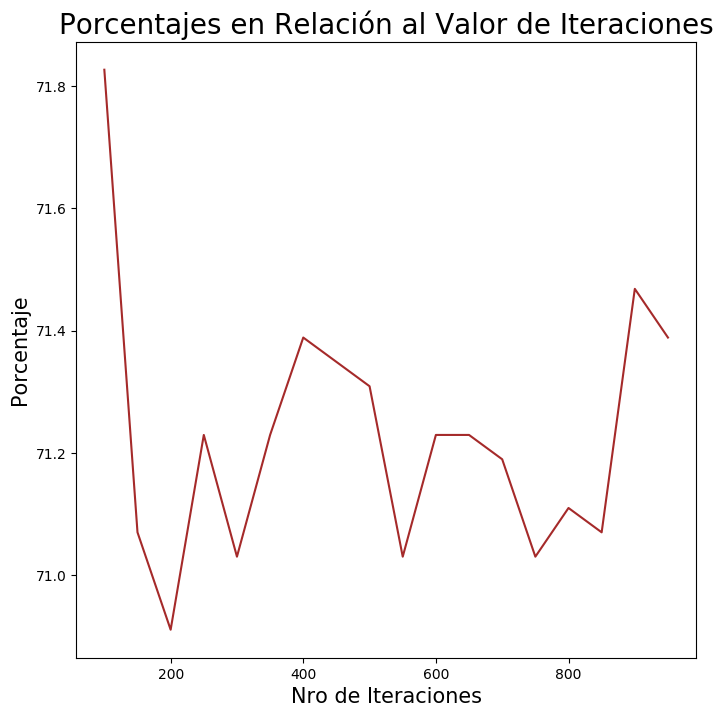

In [159]:
#Ploteamos para ver una mejor representacion
plt.subplots(figsize=(8,8))
plt.plot(rango_iteraciones,porcentajes_svm,color='brown')
plt.title("Porcentajes en Relación al Valor de Iteraciones",fontsize=20)
plt.xlabel("Nro de Iteraciones",fontsize=15)
plt.ylabel("Porcentaje",fontsize=15)

#### 3.5.1) Prediccion Final

In [136]:
SVM = svm.LinearSVC(penalty='l2',random_state=0,max_iter=100,C=1.2)

In [139]:
prediccion_test_SVM = SVM.predict(test_std)

In [140]:
test_SVM=test_final.copy()
test_SVM['target']=prediccion_test_SVM
test_SVM.head()

,0,1,2,3,4,5,6,7,8,9,...,guardian,claytonbryant,realmandyrain,zak_bagans,accionempresa,wocowae,narendramodi,rohnertparkdps,spencers,target
0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0
1,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0
2,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1
3,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1
4,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1


In [141]:
entregable_SVM=test_SVM[['id','target']]
entregable_SVM.set_index('id',inplace=True)
entregable_SVM.head()

,target
id,
0,0
2,0
3,1
9,1
11,1


In [142]:
entregable_SVM.to_csv('Resultados/SVM_Count_2.csv')

### 3.6) Multi Layer Perceptron

#### 3.6.1) Solver

##### 3.6.1.1) Lbfgs

In [188]:
MLP_lbfgs = MLPClassifier(solver='lbfgs',random_state=0)
MLP_lbfgs.fit(datos_train_std,target_train)

prediccion_MLP_lbfgs = MLP_lbfgs.predict(datos_test_std)

print('Porcentaje: {0:.2f}%'.format(accuracy_score(target_test,prediccion_MLP_lbfgs)*100))

Porcentaje: 76.40%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


##### 3.6.1.2) Sgd

In [189]:
MLP_sgd = MLPClassifier(solver='sgd',random_state=1)
MLP_sgd.fit(datos_train_std,target_train)

prediccion_MLP_sgd = MLP_sgd.predict(datos_test_std)

print('Porcentaje: {0:.2f}%'.format(accuracy_score(target_test,prediccion_MLP_sgd)*100))

Porcentaje: 77.52%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


##### 3.6.1.3) Adam

In [194]:
MLP_adam = MLPClassifier(solver='adam',random_state=1)
MLP_adam.fit(datos_train_std,target_train)

prediccion_MLP_adam = MLP_adam.predict(datos_test_std)

print('Porcentaje: {0:.2f}%'.format(accuracy_score(target_test,prediccion_MLP_adam)*100))

Porcentaje: 75.33%


#### 3.6.2) Activation

##### 3.6.2.1) Identity

In [201]:
MLP_identity = MLPClassifier(solver='sgd',activation='identity',random_state=0)
MLP_identity.fit(datos_train_std,target_train)

prediccion_MLP_identity = MLP_identity.predict(datos_test_std)

print('Porcentaje: {0:.2f}%'.format(accuracy_score(target_test,prediccion_MLP_identity)*100))

Porcentaje: 76.36%


##### 3.6.2.2) Logistic

In [202]:
MLP_logistic = MLPClassifier(solver='sgd',activation='logistic',random_state=0)
MLP_logistic.fit(datos_train_std,target_train)

prediccion_MLP_logistic = MLP_logistic.predict(datos_test_std)

print('Porcentaje: {0:.2f}%'.format(accuracy_score(target_test,prediccion_MLP_logistic)*100))

Porcentaje: 78.31%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


##### 3.6.2.3) Tanh

In [203]:
MLP_tanh = MLPClassifier(solver='sgd',activation='tanh',random_state=0)
MLP_tanh.fit(datos_train_std,target_train)

prediccion_MLP_tanh = MLP_tanh.predict(datos_test_std)

print('Porcentaje: {0:.2f}%'.format(accuracy_score(target_test,prediccion_MLP_tanh)*100))

Porcentaje: 77.52%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


##### 3.6.2.4) Relu

In [204]:
MLP_relu = MLPClassifier(solver='sgd',activation='relu',random_state=0)
MLP_relu.fit(datos_train_std,target_train)

prediccion_MLP_relu = MLP_identity.predict(datos_test_std)

print('Porcentaje: {0:.2f}%'.format(accuracy_score(target_test,prediccion_MLP_relu)*100))

Porcentaje: 76.36%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


#### 3.6.3) Max Iter

In [205]:
#Busco el valor de K que nos de el mejor porcentaje
rango_iteraciones_MLP = range(100, 500, 50)
porcentajes_MLP=[]

for iteraciones in rango_iteraciones_MLP:
    MLP = MLPClassifier(solver='sgd',activation='logistic',random_state=0,max_iter=iteraciones)
    MLP.fit(datos_train_std,target_train)
    prediccion_MLP_validacion=MLP.predict(datos_test_std)
    porcentaje=(accuracy_score(target_test,prediccion_MLP_validacion)*100)

    print('Nro Iteraciones =',iteraciones,'- Porcentaje: {0:.2f}%'.format(porcentaje))
    porcentajes_MLP.append(porcentaje)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Nro Iteraciones = 100 - Porcentaje: 79.67%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Nro Iteraciones = 150 - Porcentaje: 78.55%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Nro Iteraciones = 200 - Porcentaje: 78.31%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Nro Iteraciones = 250 - Porcentaje: 77.95%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Nro Iteraciones = 300 - Porcentaje: 77.76%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (350) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Nro Iteraciones = 350 - Porcentaje: 77.72%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Nro Iteraciones = 400 - Porcentaje: 77.76%
Nro Iteraciones = 450 - Porcentaje: 77.64%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (450) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Text(0, 0.5, 'Porcentaje')

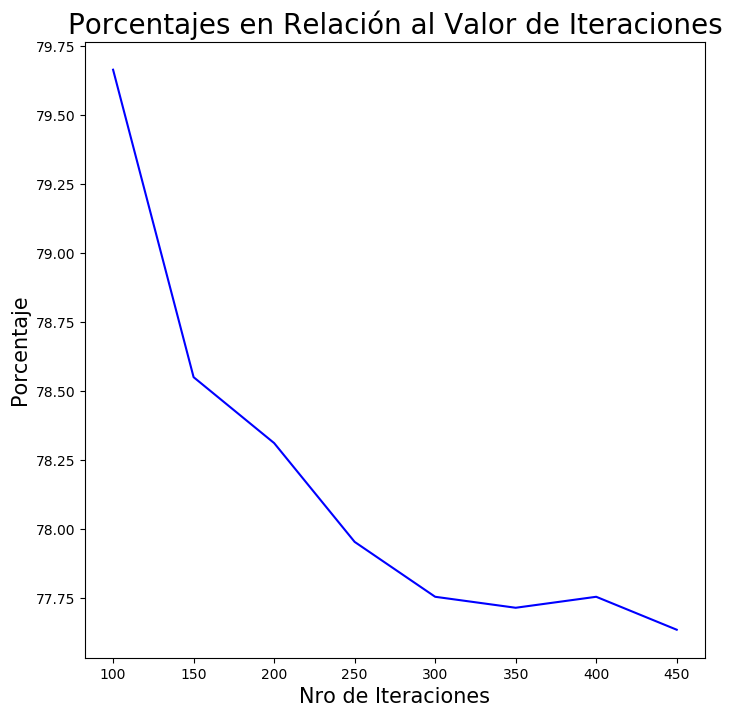

In [206]:
#Ploteamos para ver una mejor representacion
plt.subplots(figsize=(8,8))
plt.plot(rango_iteraciones_MLP,porcentajes_MLP,color='blue')
plt.title("Porcentajes en Relación al Valor de Iteraciones",fontsize=20)
plt.xlabel("Nro de Iteraciones",fontsize=15)
plt.ylabel("Porcentaje",fontsize=15)

#### 3.6.4) Prediccion Final

In [180]:
MLP = MLPClassifier(solver='sgd',activation='logistic',random_state=0,max_iter=100)

In [181]:
MLP.fit(datos_train_std,target_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [183]:
prediccion_test_MLP = MLP.predict(test_std)

In [184]:
test_MLP=test_final.copy()
test_MLP['target']=prediccion_test_MLP
test_MLP.head()

,0,1,2,3,4,5,6,7,8,9,...,guardian,claytonbryant,realmandyrain,zak_bagans,accionempresa,wocowae,narendramodi,rohnertparkdps,spencers,target
0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0
1,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0
2,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1
3,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1
4,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1


In [185]:
entregable_MLP=test_MLP[['id','target']]
entregable_MLP.set_index('id',inplace=True)
entregable_MLP.head()

,target
id,
0,0
2,0
3,1
9,1
11,1


In [186]:
entregable_MLP.to_csv('Resultados/MLP_Count_1.csv')

### 3.7) KNN

#### 3.7.1) Algoritmos

##### 3.7.1.1) Ball Tree

In [207]:
KNN_ball = KNeighborsClassifier(n_neighbors=5,algorithm='ball_tree',n_jobs=-1)
KNN_ball.fit(datos_train_std,target_train)

prediccion_KNN_ball = KNN_ball.predict(datos_test_std)

print('Porcentaje: {0:.2f}%'.format(accuracy_score(target_test,prediccion_KNN_ball)*100))

Porcentaje: 67.37%


##### 3.7.1.2) KD Tree

In [208]:
KNN_kd = KNeighborsClassifier(n_neighbors=5,algorithm='kd_tree',n_jobs=-1)
KNN_kd.fit(datos_train_std,target_train)

prediccion_KNN_kd = KNN_kd.predict(datos_test_std)

print('Porcentaje: {0:.2f}%'.format(accuracy_score(target_test,prediccion_KNN_kd)*100))

Porcentaje: 67.37%


##### 3.7.1.3) Brute

In [209]:
KNN_brute = KNeighborsClassifier(n_neighbors=5,algorithm='brute',n_jobs=-1)
KNN_brute.fit(datos_train_std,target_train)

prediccion_KNN_brute = KNN_brute.predict(datos_test_std)

print('Porcentaje: {0:.2f}%'.format(accuracy_score(target_test,prediccion_KNN_brute)*100))

Porcentaje: 67.37%


#### 3.7.2) Valor de K

In [150]:
#Busco el valor de K que nos de el mejor porcentaje
rango_k = range(1, 15)
porcentajes_euclidean=[]

for k in rango_k:
    KNN = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree',metric='euclidean',n_jobs=-1)
    KNN.fit(datos_train_std,target_train)
    prediccion_KNN_validacion=KNN.predict(datos_test_std)
    porcentaje=(accuracy_score(target_test,prediccion_KNN_validacion)*100)

    print('K =',k,'- Porcentaje: {0:.2f}%'.format(porcentaje))
    porcentajes_euclidean.append(porcentaje)

K = 1 - Porcentaje: 70.19%
K = 2 - Porcentaje: 69.92%
K = 3 - Porcentaje: 70.12%
K = 4 - Porcentaje: 67.21%
K = 5 - Porcentaje: 67.37%
K = 6 - Porcentaje: 65.14%
K = 7 - Porcentaje: 65.30%
K = 8 - Porcentaje: 64.42%
K = 9 - Porcentaje: 64.35%
K = 10 - Porcentaje: 63.79%
K = 11 - Porcentaje: 63.87%
K = 12 - Porcentaje: 63.19%
K = 13 - Porcentaje: 63.19%
K = 14 - Porcentaje: 62.63%


In [151]:
#Busco el valor de K que nos de el mejor porcentaje
rango_k = range(1, 15)
porcentajes_manhattan=[]

for k in rango_k:
    KNN = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree',metric='manhattan',n_jobs=-1)
    KNN.fit(datos_train_std,target_train)
    prediccion_KNN_validacion=KNN.predict(datos_test_std)
    porcentaje=(accuracy_score(target_test,prediccion_KNN_validacion)*100)

    print('K =',k,'- Porcentaje: {0:.2f}%'.format(porcentaje))
    porcentajes_manhattan.append(porcentaje)

K = 1 - Porcentaje: 72.11%
K = 2 - Porcentaje: 69.84%
K = 3 - Porcentaje: 69.84%
K = 4 - Porcentaje: 67.49%
K = 5 - Porcentaje: 67.53%
K = 6 - Porcentaje: 66.30%
K = 7 - Porcentaje: 66.41%
K = 8 - Porcentaje: 65.10%
K = 9 - Porcentaje: 65.22%
K = 10 - Porcentaje: 64.27%
K = 11 - Porcentaje: 64.46%
K = 12 - Porcentaje: 63.91%
K = 13 - Porcentaje: 63.99%
K = 14 - Porcentaje: 63.19%


In [152]:
#Busco el valor de K que nos de el mejor porcentaje
rango_k = range(1, 15)
porcentajes_chebyshev=[]

for k in rango_k:
    KNN = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree',metric='chebyshev',n_jobs=-1)
    KNN.fit(datos_train_std,target_train)
    prediccion_KNN_validacion=KNN.predict(datos_test_std)
    porcentaje=(accuracy_score(target_test,prediccion_KNN_validacion)*100)

    print('K =',k,'- Porcentaje: {0:.2f}%'.format(porcentaje))
    porcentajes_chebyshev.append(porcentaje)

K = 1 - Porcentaje: 64.39%
K = 2 - Porcentaje: 64.58%
K = 3 - Porcentaje: 60.92%
K = 4 - Porcentaje: 61.20%
K = 5 - Porcentaje: 59.57%
K = 6 - Porcentaje: 59.69%
K = 7 - Porcentaje: 58.26%
K = 8 - Porcentaje: 58.30%
K = 9 - Porcentaje: 58.34%
K = 10 - Porcentaje: 58.77%
K = 11 - Porcentaje: 57.58%
K = 12 - Porcentaje: 58.81%
K = 13 - Porcentaje: 57.42%
K = 14 - Porcentaje: 58.81%


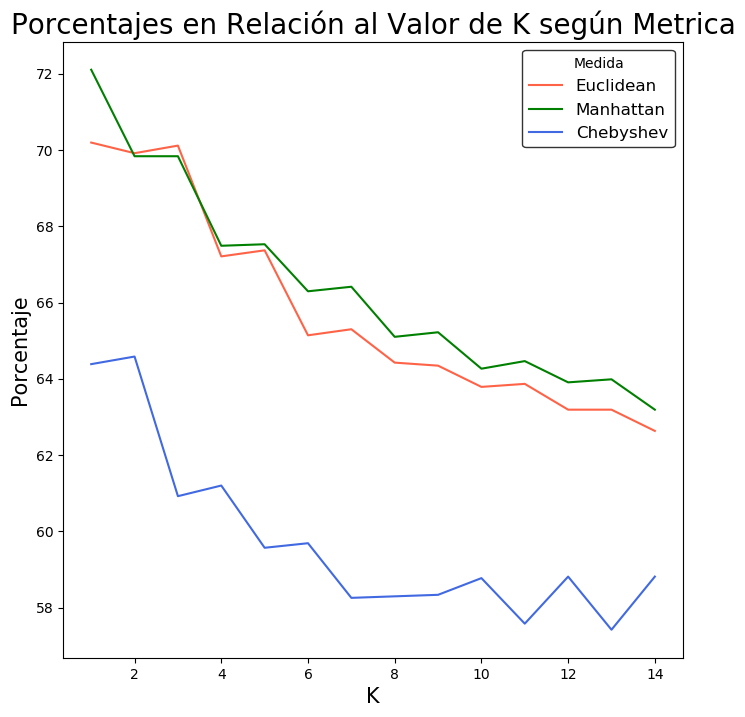

In [153]:
#Ploteamos para ver una mejor representacion
plt.subplots(figsize=(8,8))
plt.plot(rango_k,porcentajes_euclidean,color='tomato')
plt.plot(rango_k,porcentajes_manhattan,color='green')
plt.plot(rango_k,porcentajes_chebyshev,color='royalblue')
plt.title("Porcentajes en Relación al Valor de K según Metrica",fontsize=20)
plt.xlabel("K",fontsize=15)
plt.ylabel("Porcentaje",fontsize=15)
leyenda=plt.legend(['Euclidean','Manhattan','Chebyshev'],fontsize=12,title='Medida',frameon=True,facecolor='white',edgecolor='black')
leyenda.get_frame().set_linewidth(1.0)

#### 3.7.3) Predicción Final

In [127]:
KNN = KNeighborsClassifier(n_neighbors=1,algorithm='kd_tree',metric='manhattan',n_jobs=-1)

In [128]:
KNN.fit(datos_train_std,target_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
                     weights='uniform')

In [129]:
prediccion_test_KNN = KNN.predict(test_std)

In [130]:
test_KNN=test_final.copy()
test_KNN['target']=prediccion_test_KNN
test_KNN.head()

,0,1,2,3,4,5,6,7,8,9,...,spinningbot,itunesmusic,nickcannon,itunes,tflbusalerts,dannyonpc,davidvonderhaar,worldnetdaily,smh,target
0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0
1,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1
2,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1
3,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0
4,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0


In [131]:
entregable_KNN=test_KNN[['id','target']]
entregable_KNN.set_index('id',inplace=True)
entregable_KNN.head()

,target
id,
0,0
2,1
3,1
9,0
11,0


In [132]:
entregable_KNN.to_csv('Resultados/KNN_Count_2.csv')

### 3.8) Árboles de Decisión

#### 3.8.1) Splitter

##### 3.8.1.1) Best

In [210]:
tree_best = DecisionTreeClassifier(random_state=0,splitter='best')
tree_best.fit(datos_train,target_train)

prediccion_tree_best = tree_best.predict(datos_test)

print('Porcentaje: {0:.2f}%'.format(accuracy_score(target_test,prediccion_tree_best)*100))

Porcentaje: 72.78%


##### 3.8.1.2) Random

In [211]:
tree_random = DecisionTreeClassifier(random_state=0,splitter='random')
tree_random.fit(datos_train,target_train)

prediccion_tree_random = tree_random.predict(datos_test)

print('Porcentaje: {0:.2f}%'.format(accuracy_score(target_test,prediccion_tree_random)*100))

Porcentaje: 72.86%


#### 3.8.2) Criterion

##### 3.8.2.1) Gini

In [212]:
tree_gini = DecisionTreeClassifier(random_state=0,criterion='gini',splitter='random')
tree_gini.fit(datos_train,target_train)

prediccion_tree_gini = tree_gini.predict(datos_test)

print('Porcentaje: {0:.2f}%'.format(accuracy_score(target_test,prediccion_tree_gini)*100))

Porcentaje: 72.86%


##### 3.8.2.2) Entropy

In [213]:
tree_entropy = DecisionTreeClassifier(random_state=0,criterion='entropy',splitter='random')
tree_entropy.fit(datos_train,target_train)

prediccion_tree_entropy = tree_entropy.predict(datos_test)

print('Porcentaje: {0:.2f}%'.format(accuracy_score(target_test,prediccion_tree_entropy)*100))

Porcentaje: 71.83%


#### 3.8.3) Max Features

##### 3.8.3.1) Sqrt

In [214]:
tree_sqrt = DecisionTreeClassifier(random_state=0,criterion='gini',splitter='random',max_features='sqrt')
tree_sqrt.fit(datos_train,target_train)

prediccion_tree_sqrt = tree_sqrt.predict(datos_test)

print('Porcentaje: {0:.2f}%'.format(accuracy_score(target_test,prediccion_tree_sqrt)*100))

Porcentaje: 71.47%


##### 3.8.3.1) Log2

In [215]:
tree_log2 = DecisionTreeClassifier(random_state=0,criterion='entropy',splitter='random',max_features='log2')
tree_log2.fit(datos_train,target_train)

prediccion_tree_log2 = tree_log2.predict(datos_test)

print('Porcentaje: {0:.2f}%'.format(accuracy_score(target_test,prediccion_tree_log2)*100))

Porcentaje: 68.72%


#### 3.8.4) Prediccion Final

In [216]:
tree = DecisionTreeClassifier(random_state=0,criterion='entropy',splitter='random')

In [217]:
tree.fit(datos_train,target_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='random')

In [219]:
prediccion_test_tree = tree.predict(test_final)

In [220]:
test_tree=test_final.copy()
test_tree['target']=prediccion_test_tree
test_tree.head()

,0,1,2,3,4,5,6,7,8,9,...,guardian,claytonbryant,realmandyrain,zak_bagans,accionempresa,wocowae,narendramodi,rohnertparkdps,spencers,target
0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0
1,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1
2,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1
3,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1
4,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1


In [221]:
entregable_tree=test_tree[['id','target']]
entregable_tree.set_index('id',inplace=True)
entregable_tree.head()

,target
id,
0,0
2,1
3,1
9,1
11,1


In [222]:
entregable_tree.to_csv('Resultados/ArbolDecision_Count_2.csv')

### 3.9) Ada Boosting

In [223]:
#Busco el valor de K que nos de el mejor porcentaje
rango_iteraciones_ada = range(100, 500, 50)
porcentajes_ada=[]

for iteraciones in rango_iteraciones_ada:
    ada = AdaBoostClassifier(n_estimators=iteraciones, random_state=0)
    ada.fit(datos_train_std,target_train)
    prediccion_ada_validacion=ada.predict(datos_test_std)
    porcentaje=(accuracy_score(target_test,prediccion_ada_validacion)*100)

    print('Nro Iteraciones =',iteraciones,'- Porcentaje: {0:.2f}%'.format(porcentaje))
    porcentajes_ada.append(porcentaje)

Nro Iteraciones = 100 - Porcentaje: 77.88%
Nro Iteraciones = 150 - Porcentaje: 77.60%
Nro Iteraciones = 200 - Porcentaje: 78.43%
Nro Iteraciones = 250 - Porcentaje: 78.03%
Nro Iteraciones = 300 - Porcentaje: 77.80%
Nro Iteraciones = 350 - Porcentaje: 77.99%
Nro Iteraciones = 400 - Porcentaje: 77.91%
Nro Iteraciones = 450 - Porcentaje: 77.12%


Text(0, 0.5, 'Porcentaje')

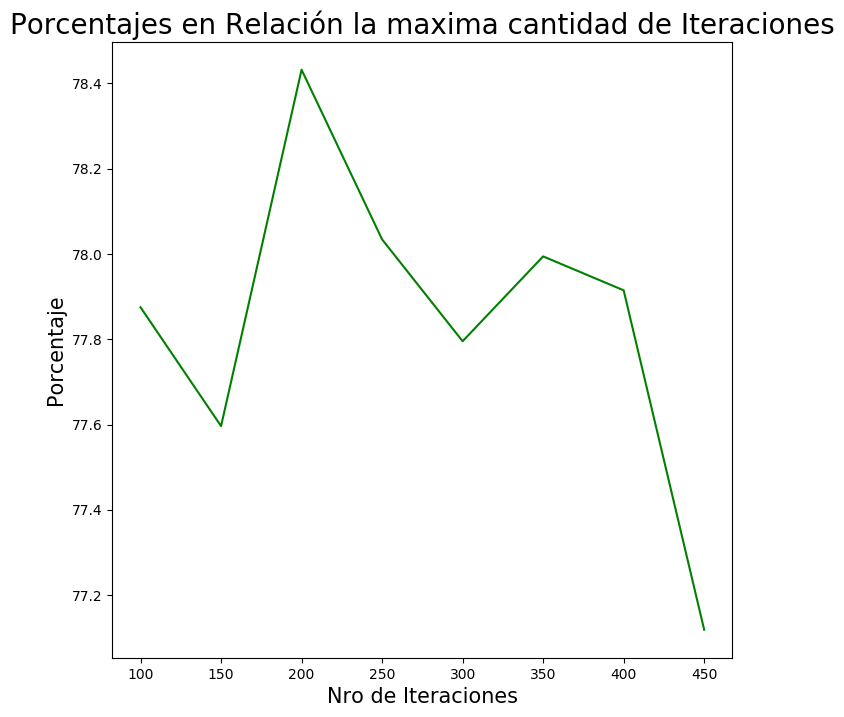

In [224]:
#Ploteamos para ver una mejor representacion
plt.subplots(figsize=(8,8))
plt.plot(rango_iteraciones_ada,porcentajes_ada,color='green')
plt.title("Porcentajes en Relación la maxima cantidad de Iteraciones",fontsize=20)
plt.xlabel("Nro de Iteraciones",fontsize=15)
plt.ylabel("Porcentaje",fontsize=15)

#### 3.9.1) Predicción Final

In [225]:
ada = AdaBoostClassifier(n_estimators=200, random_state=0)

In [227]:
ada.fit(datos_train_std,target_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=200, random_state=0)

In [228]:
prediccion_test_ada = ada.predict(test_final)

In [229]:
test_ada=test_final.copy()
test_ada['target']=prediccion_test_ada
test_ada.head()

,0,1,2,3,4,5,6,7,8,9,...,guardian,claytonbryant,realmandyrain,zak_bagans,accionempresa,wocowae,narendramodi,rohnertparkdps,spencers,target
0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0
1,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0
2,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0
3,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0
4,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1


In [230]:
entregable_ada=test_ada[['id','target']]
entregable_ada.set_index('id',inplace=True)
entregable_ada.head()

,target
id,
0,0
2,0
3,0
9,0
11,1


In [231]:
entregable_ada.to_csv('Resultados/AdaBoosting_Count_2.csv')

### 3.11) Bagging Random Forest

In [232]:
bagging_RF = BaggingClassifier(base_estimator=RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=200),n_estimators=200,random_state=0)

In [233]:
bagging_RF.fit(datos_train,target_train)

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True,
                                                        ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features='auto',
                                                        max_leaf_nodes=None,
                                                        max_samples=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
     

In [234]:
prediccion_bagging_RF = bagging_RF.predict(datos_test)

print('Porcentaje: {0:.2f}%'.format(accuracy_score(target_test,prediccion_bagging_RF)*100))

Porcentaje: 80.54%


In [236]:
prediccion_test_bagging_RF = bagging_RF.predict(test_final)

In [237]:
test_bagging_RF=test_final.copy()
test_bagging_RF['target']=prediccion_test_bagging_RF
test_bagging_RF.head()

,0,1,2,3,4,5,6,7,8,9,...,guardian,claytonbryant,realmandyrain,zak_bagans,accionempresa,wocowae,narendramodi,rohnertparkdps,spencers,target
0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0
1,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1
2,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1
3,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1
4,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1


In [238]:
entregable_bagging_RF=test_bagging_RF[['id','target']]
entregable_bagging_RF.set_index('id',inplace=True)
entregable_bagging_RF.head()

,target
id,
0,0
2,1
3,1
9,1
11,1


In [239]:
entregable_bagging_RF.to_csv('Resultados/Bagging_RF_Count_2.csv')

### 3.12) Voting Classifier

In [258]:
RF1 = RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=500, oob_score=True,max_features='log2',min_samples_split=50)
RF2 = RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=600, oob_score=True,max_features='log2',min_samples_split=50)
RF3 = RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=750, oob_score=True,max_features='log2',min_samples_split=50)

In [259]:
voting = VotingClassifier(estimators=[('rf1', RF1), ('rf2', RF2), ('rf3', RF3)],voting='hard')

In [260]:
voting.fit(datos_train,target_train)

VotingClassifier(estimators=[('rf1',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='log2',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=50,
                                                     min_weight_fraction_leaf=0.0,
      

In [261]:
prediccion_voting = voting.predict(datos_test)

print('Porcentaje: {0:.2f}%'.format(accuracy_score(target_test,prediccion_voting)*100))

Porcentaje: 81.26%


In [262]:
prediccion_test_voting = voting.predict(test_final)

In [263]:
test_voting=test_final.copy()
test_voting['target']=prediccion_test_voting
test_voting.head()

,0,1,2,3,4,5,6,7,8,9,...,guardian,claytonbryant,realmandyrain,zak_bagans,accionempresa,wocowae,narendramodi,rohnertparkdps,spencers,target
0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,0
1,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1
2,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1
3,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1
4,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,False,1


In [264]:
entregable_voting=test_voting[['id','target']]
entregable_voting.set_index('id',inplace=True)
entregable_voting.head()

,target
id,
0,0
2,1
3,1
9,1
11,1


In [265]:
entregable_voting.to_csv('Resultados/Voting_Count_3.csv')

### 3.13) Ensamble manual de Random Forest

In [312]:
#Busco el Nro. Estimadores que nos de el mejor porcentaje
rango_n = range(100, 1200, 50)
predicciones=[]

for n in rango_n:
    RF = RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=n, oob_score=True,max_features='log2',min_samples_split=50)
    RF.fit(datos_train,target_train)
    prediccion_RF_validacion=RF.predict(datos_test)
    porcentaje_RF=(accuracy_score(target_test,prediccion_RF_validacion)*100)

    print('Nro. Estimadores =',n,'- Porcentaje: {0:.2f}%'.format(porcentaje_RF))
    porcentajes_RF.append(porcentaje_RF)
    
    prediccion_test_RF = RF.predict(test_final)
    prediccion_test_RF = prediccion_test_RF.astype(int)
    
    entregable = test_final[['id']].copy()
    entregable['target'] = prediccion_test_RF
    entregable.index = entregable['id']
    entregable.drop(columns = 'id', inplace = True)

    predicciones.append(entregable)

Nro. Estimadores = 100 - Porcentaje: 80.70%
Nro. Estimadores = 150 - Porcentaje: 81.02%
Nro. Estimadores = 200 - Porcentaje: 80.86%
Nro. Estimadores = 250 - Porcentaje: 80.66%
Nro. Estimadores = 300 - Porcentaje: 80.78%
Nro. Estimadores = 350 - Porcentaje: 80.94%
Nro. Estimadores = 400 - Porcentaje: 81.14%
Nro. Estimadores = 450 - Porcentaje: 81.18%
Nro. Estimadores = 500 - Porcentaje: 81.34%
Nro. Estimadores = 550 - Porcentaje: 81.26%
Nro. Estimadores = 600 - Porcentaje: 81.30%
Nro. Estimadores = 650 - Porcentaje: 81.26%
Nro. Estimadores = 700 - Porcentaje: 81.26%
Nro. Estimadores = 750 - Porcentaje: 81.34%
Nro. Estimadores = 800 - Porcentaje: 81.18%
Nro. Estimadores = 850 - Porcentaje: 81.26%
Nro. Estimadores = 900 - Porcentaje: 81.10%
Nro. Estimadores = 950 - Porcentaje: 81.06%
Nro. Estimadores = 1000 - Porcentaje: 81.06%
Nro. Estimadores = 1050 - Porcentaje: 81.10%
Nro. Estimadores = 1100 - Porcentaje: 81.18%
Nro. Estimadores = 1150 - Porcentaje: 81.14%


In [313]:
predicciones_concat = pd.concat(predicciones)
ensamble = predicciones_concat.groupby('id').agg({'target':'mean'})
ensamble['target']=ensamble['target'].apply(round)
ensamble.head()

,target
id,
0,0
2,1
3,1
9,1
11,1


In [314]:
ensamble.to_csv('Resultados/RF_Ensamble_Count_3.csv')